### paper plots

pretty plots for final paper

In [1]:
!jt -t oceans16 -fs 10 -cellw 93% -nfs 10 -lineh 120 -tfs 10 -dfs 8 -ofs 8 -mathfs 100

In [1]:
import autoencodeSVJ.utils as utils
import autoencodeSVJ.evaluate as ev
import glob
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from collections import OrderedDict as odict
import pandas as pd
import glob
import os
import tensorflow as tf

%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

reload(ev)
reload(utils)

Using TensorFlow backend.


<module 'autoencodeSVJ.utils' from '/afs/cern.ch/user/l/llepotti/.local/lib/python2.7/site-packages/autoencodeSVJ/utils.pyc'>

In [2]:
ev.update_all_signal_evals()

found 0 trainings total


In [2]:
aucs = ev.load_auc_table()
aucs_old = ev.load_auc_table('TEST')
bdts = pd.read_csv('autoencode/data/bdt_aucs.csv')
bdts = bdts[bdts.columns[1:]].set_index(bdts[bdts.columns[0]].rename('mass'))
bdts = bdts.T.set_index(bdts.T.index.rename('nu')).T
bdts.columns = map(float, bdts.columns)
bdts.index = map(float, bdts.index)

In [3]:
import datetime

s = utils.summary()
# s = s.cdrop(['target_dim', 'signal_path', 'qcd_path', 'range', 'filepath', 'end_time', 'summary_path', 'ae_type', 'time', 'arch', 'hlf', 'input_dim'])
s = s[s.epochs > 10]
s = s[s.norm_percentile == 25]
# s = s[s.time > datetime.datetime(year=2020, month=5, day=20)]
s = s.set_index('filename').sort_index()
a2 = aucs.iloc[:,aucs.columns.isin(s.index)]
s['aucs'] = a2.mean().sort_index()

In [199]:
import math

cols = 3
rows = int(math.ceil(float(len(s))/cols))

# fig, axs = plt.subplots(rows, cols, figsize=(6*cols, 3*rows))

# axs = axs.flatten()

rets = []
for i,elt in enumerate(s.index):
    t = ev.check_training(elt)
#     t.drop('lr', axis=1).plot(ax=axs[i])
    t['lr'] = t.lr/0.1
#     t.plot(ax=axs[i])
    rets.append(t.loss.iloc[-1])
#     axs[i].set_ylim(0.0045, 0.05)
#     axs[i].set_title('{}: {:.4f}'.format(s.loc[elt].time, s.loc[elt].mae_auc), fontsize=18)

# plt.tight_layout()
# plt.show()

s['mse'] = rets

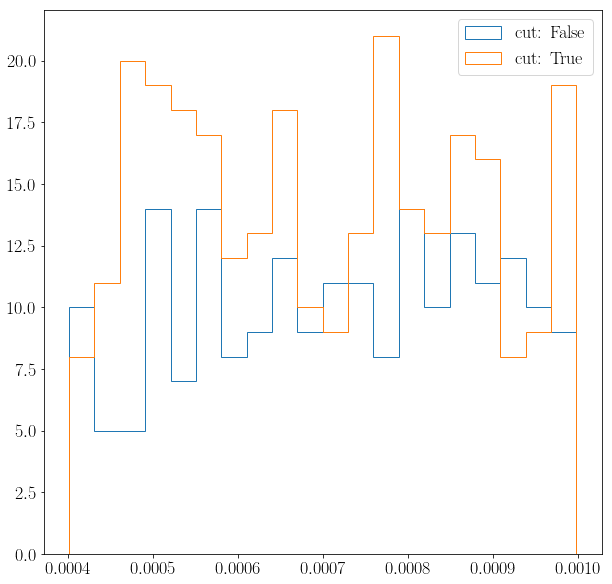

In [5]:
elts = np.load('train/elts.npz')
ets = [tuple(e) for e in elts]
# pd.Series(ets).isin(set(pd.Series(list(zip(s.target_dim.astype(float), s.batch_size.astype(float), s.learning_rate)))))
es = s[pd.Series(list(zip(s.target_dim.astype(float), s.batch_size.astype(float), s.learning_rate))).isin(ets).values].copy()

sp = s.copy()
cut = sp.total_loss < 0.0075

def plot_along_col(data, x, y, col, hist=False):
    for val in data[col].unique():
        elt = data[data[col] == val]
        if hist:
            plt.hist(elt[x], label='{}: {}'.format(col, val), histtype='step', range=(data[x].min(), data[x].max()), bins=20)
        else:
            plt.scatter(elt[x], elt[y], label='{}: {}'.format(col, val))
    plt.legend()
    return plt.gcf()

cp = sp.copy()
cp['cut'] = cut
ax = plot_along_col(cp, 'learning_rate', 'aucs', 'cut', hist=True)
# plt.xlim(0, 0.002)
plt.show()

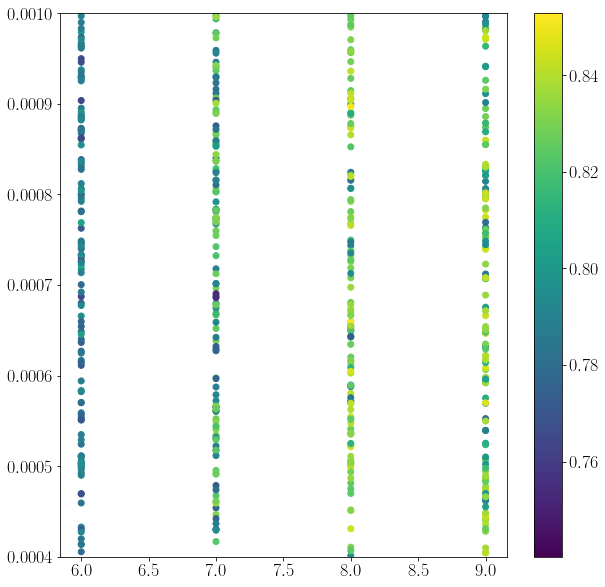

In [6]:
plt.scatter(sp.target_dim, sp.learning_rate, c=sp.aucs)
plt.colorbar()
plt.ylim(.0004, .001)
plt.show()

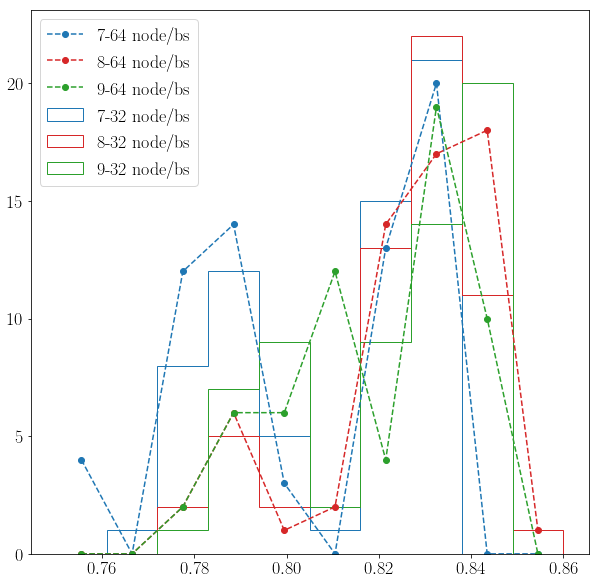

In [7]:
n_bins = 10
colors = ['black', 'tab:blue', 'tab:red', 'tab:green']
styles = [
    {'alpha': 0.4},
    {'linestyle': '--'}
]

for i,dim in enumerate(s.target_dim.unique()):
    if dim == 6:
        continue
    sub = s[s.target_dim == dim]
    
    for j,bs in enumerate(sorted(s.batch_size.unique())):
        ssub = sub[sub.batch_size == bs]
        
        style = styles[j]
        
        if j == 0:
#             plt.bar(bins[1:], height=h, width=np.diff(bins), label='{}-{} node/bs'.format(dim, bs), color=colors[i], alpha=0.3)
            plt.hist(ssub.aucs, range=(0.75, 0.86), bins=n_bins, label='{}-{} node/bs'.format(dim, bs), color=colors[i], histtype='step')

        else:
            h, bins = np.histogram(ssub.aucs, range=(0.75, 0.86), bins=n_bins)

            plt.plot(bins[:-1] + 0.5*np.diff(bins), h, label='{}-{} node/bs'.format(dim, bs), color=colors[i], marker='o', linestyle='--')
#         plt.hist(ssub.aucs, range=(0.75, 0.86), bins=20, label='{}-{} node/bs'.format(dim, bs), color=colors[i], **styles[j])
    
plt.legend()
plt.show()

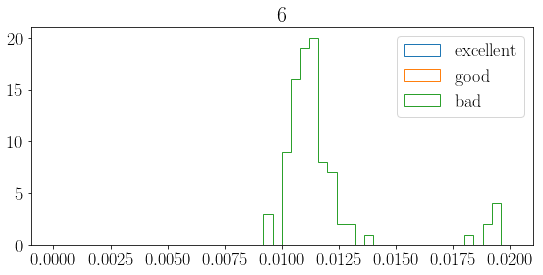

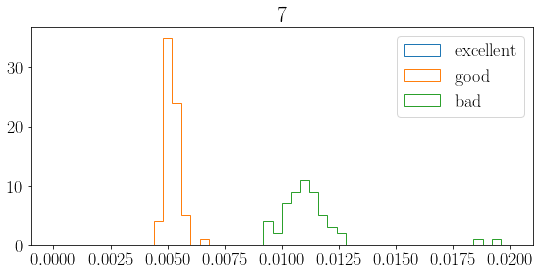

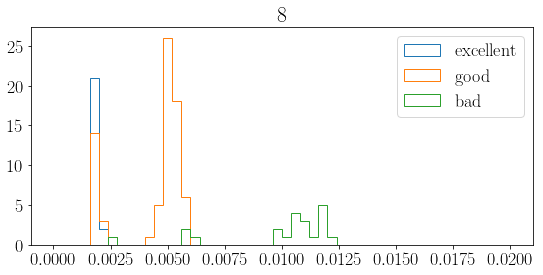

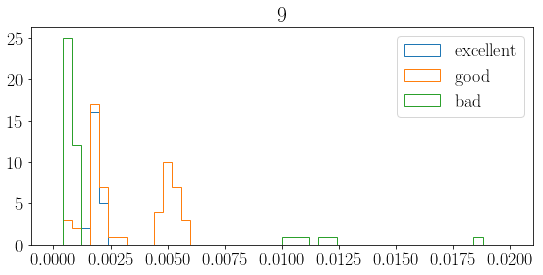

In [12]:
params = {
    'histtype': 'step',
#     'alpha': 0.3,
    'range': (0, .02),
    'bins': 50
}

bar_data = []

for dim in s.target_dim.unique():
    plt.figure(figsize=(9,4))
    plt.title(dim)
    se = s.copy()
    se = se[se.target_dim == dim]
    # se = se[se.target_dim < 9]

    def apply_label(x):
        if x < .815:
            return 'bad'
        if x < .84:
            return 'good'
        return 'excellent'
    
    se['res'] = se.aucs.apply(apply_label)
    bar_data.append(se.drop([c for c in se.columns if c not in ['batch_size', 'target_dim', 'res']], axis=1))
#     bd = se.groupby(['batch_size']).res.value_counts().unstack().fillna(0)
#     bd.index = ['{}_{}'.format(dim, x) for x in bd.index]
    
#     bad = se[se.aucs < 0.815]
#     good = se[(se.aucs > 0.815) & (s.aucs < .84)]
#     ex = se[se.aucs > .84] 

    for lab in ['excellent', 'good', 'bad']:
    
        plt.hist(se[se.res == lab].total_loss, label=lab, **params)
#     plt.hist(good.total_loss, label='good', **params)
#     plt.hist(bad.total_loss, label='bad', **params)
    plt.legend()
    plt.show()
    
bar_data = pd.concat(bar_data)

In [37]:
tg = bar_data.groupby(['batch_size', 'target_dim']).res.value_counts().unstack().fillna(0).reset_index()
tg = pd.melt(tg, id_vars=['batch_size', 'target_dim'], var_name='quality', value_name='count')
tg.rename({'batch_size': 'batch size', 'target_dim': 'target dim'}, axis=1, inplace=True)

order = {
    'bad': 0,
    'good': 1,
    'excellent': 2
}

tg['order'] = tg.quality.map(order)
tg = tg.sort_values('order').drop('order', axis=1)

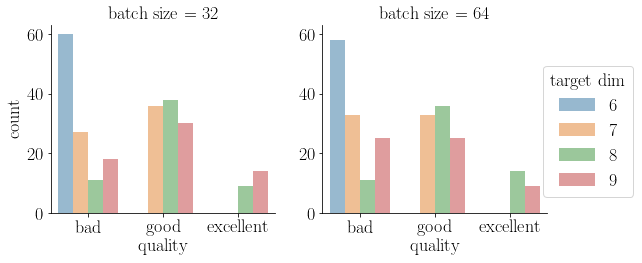

In [38]:
import seaborn.apionly as sns
# fig, ax = plt.subplots(figsize=(10,4))
sns.factorplot(x='quality', y='count', col='batch size', hue='target dim', data=tg, kind='bar', alpha=.5)
# sns.factorplot(x='quality', y='count', hue='target dim', data=tg[tg['batch size']==64], kind='count', ax=ax, alpha=.5)
plt.show()

In [144]:
cut = s[s.target_dim.isin([8, 9])].copy()
best = cut[cut.index.isin(bar_data[bar_data.res == 'excellent'].index)]
others = cut[~cut.index.isin(best.index)]

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in divide
  if sys.path[0] == '':
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in divide
  if sys.path[0] == '':
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/matplotlib/axes/_axes.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  in cbook.safezip(data, err)]


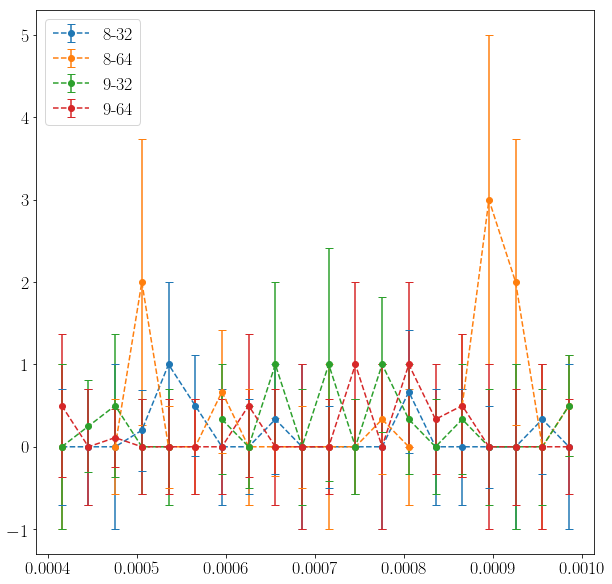

In [83]:
rng = .0004, .001
bins = 20
norm = 0

for dim in [8, 9]:
    for bs in [32, 64]:
        Fb,x = np.histogram(best[(best.target_dim == dim) & (best.batch_size == bs)].learning_rate, range=rng, bins=bins, normed=norm)
        Fo,x = np.histogram(others[(others.target_dim == dim) & (others.batch_size == bs)].learning_rate, range=rng, bins=bins, normed=norm)
        nb,x = np.histogram(best[(best.target_dim == dim) & (best.batch_size == bs)].learning_rate, range=rng, bins=bins, normed=0)
        no,x = np.histogram(others[(others.target_dim == dim) & (others.batch_size == bs)].learning_rate, range=rng, bins=bins, normed=0)

        plt.errorbar(x[:-1] + 0.5*np.diff(x), Fb.astype(float)/Fo.astype(float), yerr=np.sqrt(nb + no)/no, fmt='o', linestyle='--', capsize=4, label='{}-{}'.format(dim, bs))
        
plt.legend()
plt.show()

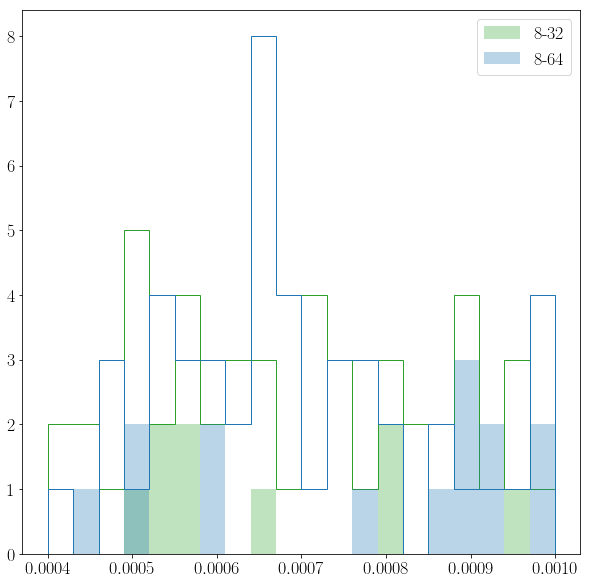

In [98]:
i = 0
rng = .0004, .001
bins = 20
colors = ['tab:green', 'tab:blue', 'black', 'tab:orange']
for dim in [8]:
    for bs in [32, 64]:
        plt.hist(best[(best.target_dim == dim) & (best.batch_size == bs)].learning_rate, range=rng, bins=bins, normed=norm, histtype='bar', alpha=0.3, color=colors[i], label='{}-{}'.format(dim, bs))
        plt.hist(others[(others.target_dim == dim) & (others.batch_size == bs)].learning_rate, range=rng, bins=bins, normed=norm, histtype='step', color=colors[i])
        i += 1
plt.legend()
plt.show()
    
                            
# plt.hist(others.learning_rate, range=(.0004, .001), bins=20, histtype='step')
# plt.hist(best.learning_rate, range=(.0004, .001), bins=20, histtype='step')

(0.0, 0.015)

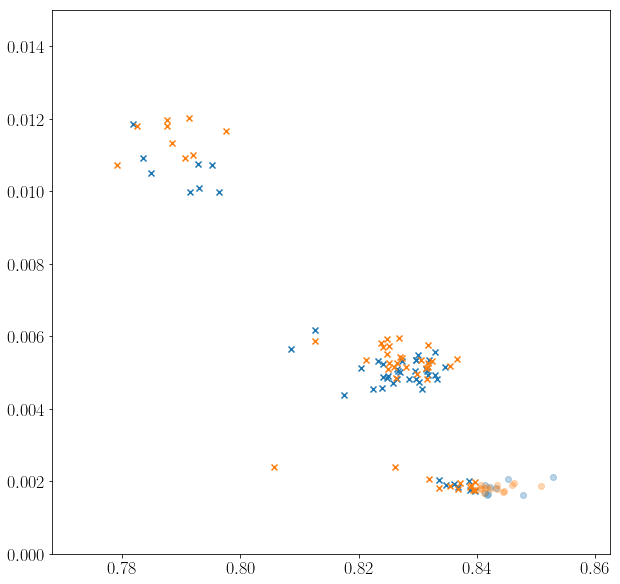

In [114]:
colors = ['tab:blue', 'tab:orange']

for i,bs in enumerate([32, 64]):
    plt.scatter(best[best.batch_size == bs].aucs, best[best.batch_size == bs].total_loss, color=colors[i], alpha=.3)
    plt.scatter(others[others.batch_size == bs].aucs, others[others.batch_size == bs].total_loss, color=colors[i], marker='x')

plt.ylim(0.000, 0.015)

In [166]:
best.sort_values('total_loss')

,VID,ae_type,arch,batch_size,eflow,eflow_base,end_time,epochs,es_patience,filepath,...,seed,signal_path,start_time,summary_path,target_dim,test_split,time,total_loss,val_split,aucs
filename,,,,,,,,,,,,,,,,,,,,,
hlf_eflow3_8_v144,8.0,NaN,"[19, 30, 30, 8, 30, 30, 19]",32,True,3,2020-06-04 10:06:13.386671,100,12.0,/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW...,...,32117957,data/all_signals/2000GeV_0.15/base_3/*.h5,2020-06-04 09:58:41.749588,/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW...,8,0.15,2020-06-04 10:06:14,0.001626,0.15,0.847801
hlf_eflow3_8_v90,8.0,NaN,"[19, 30, 30, 8, 30, 30, 19]",32,True,3,2020-06-03 07:17:29.216129,100,12.0,/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW...,...,82175973,data/all_signals/2000GeV_0.15/base_3/*.h5,2020-06-03 07:09:46.119791,/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW...,8,0.15,2020-06-03 07:17:30,0.001637,0.15,0.841760
hlf_eflow3_8_v104,8.0,NaN,"[19, 30, 30, 8, 30, 30, 19]",32,True,3,2020-06-03 11:38:23.471625,100,12.0,/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW...,...,39330549,data/all_signals/2000GeV_0.15/base_3/*.h5,2020-06-03 11:30:30.811787,/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW...,8,0.15,2020-06-03 11:38:24,0.001654,0.15,0.841865
hlf_eflow3_8_v63,8.0,NaN,"[19, 30, 30, 8, 30, 30, 19]",32,True,3,2020-06-02 08:54:52.017128,100,12.0,/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW...,...,29497536,data/all_signals/2000GeV_0.15/base_3/*.h5,2020-06-02 08:42:54.179764,/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW...,8,0.15,2020-06-02 08:54:59,0.001672,0.15,0.841291
hlf_eflow3_8_v82,8.0,NaN,"[19, 30, 30, 8, 30, 30, 19]",64,True,3,2020-06-03 04:56:36.969471,100,12.0,/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW...,...,94526478,data/all_signals/2000GeV_0.15/base_3/*.h5,2020-06-03 04:52:36.448453,/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW...,8,0.15,2020-06-03 04:56:38,0.001691,0.15,0.841181
hlf_eflow3_8_v152,8.0,NaN,"[19, 30, 30, 8, 30, 30, 19]",64,True,3,2020-06-04 23:49:05.065094,100,12.0,/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW...,...,65843224,data/all_signals/2000GeV_0.15/base_3/*.h5,2020-06-04 23:45:07.300874,/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW...,8,0.15,2020-06-04 23:49:06,0.001709,0.15,0.844456
hlf_eflow3_8_v138,8.0,NaN,"[19, 30, 30, 8, 30, 30, 19]",64,True,3,2020-06-04 08:30:34.297603,100,12.0,/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW...,...,52078921,data/all_signals/2000GeV_0.15/base_3/*.h5,2020-06-04 08:26:36.300662,/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW...,8,0.15,2020-06-04 08:30:35,0.001745,0.15,0.844637
hlf_eflow3_8_v85,8.0,NaN,"[19, 30, 30, 8, 30, 30, 19]",64,True,3,2020-06-03 06:22:38.765621,100,12.0,/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW...,...,38104410,data/all_signals/2000GeV_0.15/base_3/*.h5,2020-06-03 06:18:39.748571,/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW...,8,0.15,2020-06-03 06:22:39,0.001783,0.15,0.843403
hlf_eflow3_8_v148,8.0,NaN,"[19, 30, 30, 8, 30, 30, 19]",64,True,3,2020-06-04 21:27:02.542373,100,12.0,/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW...,...,78988615,data/all_signals/2000GeV_0.15/base_3/*.h5,2020-06-04 21:23:05.910568,/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW...,8,0.15,2020-06-04 21:27:03,0.001789,0.15,0.842151


0.0009

In [205]:
cut = s[(s.target_dim == 8) & (s.batch_size == 64) & (s.learning_rate > 0.0008) & (s.learning_rate < 0.001)]
cut.total_loss.sort_values()

filename
hlf_eflow3_8_v82     0.001691
hlf_eflow3_8_v138    0.001745
hlf_eflow3_8_v67     0.001768
hlf_eflow3_8_v85     0.001783
hlf_eflow3_8_v148    0.001789
hlf_eflow3_8_v97     0.001807
hlf_eflow3_8_v79     0.001852
hlf_eflow3_8_v68     0.001861
hlf_eflow3_8_v53     0.001898
hlf_eflow3_8_v125    0.001967
hlf_eflow3_8_v105    0.002409
hlf_eflow3_8_v109    0.004820
hlf_eflow3_8_v161    0.005089
hlf_eflow3_8_v132    0.005119
hlf_eflow3_8_v140    0.005257
hlf_eflow3_8_v162    0.005431
hlf_eflow3_8_v75     0.005729
Name: total_loss, dtype: float64

In [160]:
cut = s[s.target_dim.isin([8])].copy()
best = cut[cut.index.isin(bar_data[bar_data.res == 'excellent'].index)]
others = cut[~cut.index.isin(best.index)]

In [44]:
corr = s.drop(['mae_auc', 'mse_auc', 'seed'], axis=1).corr(method='pearson')
corr.loc[~corr.isna().all(axis=0), ~corr.isna().all(axis=1)].round(5)

,batch_size,learning_rate,target_dim,test_split,total_loss,val_split,aucs
batch_size,1.00000,0.02458,-0.00277,-0.0,-0.00393,-0.0,-0.03840
learning_rate,0.02458,1.00000,-0.07223,-0.0,0.00009,-0.0,-0.04523
target_dim,-0.00277,-0.07223,1.00000,-0.0,-0.66138,-0.0,0.58546
test_split,-0.00000,-0.00000,-0.00000,1.0,-0.00000,1.0,-0.00000
total_loss,-0.00393,0.00009,-0.66138,-0.0,1.00000,-0.0,-0.76142
val_split,-0.00000,-0.00000,-0.00000,1.0,-0.00000,1.0,-0.00000
aucs,-0.03840,-0.04523,0.58546,-0.0,-0.76142,-0.0,1.00000


In [128]:
# # plt.scatter(s.mse, s.learning_rate)
# # plt.show()
# hq = 'lr_factor'
# rng = (0.0, 1)
# plt.hist(s[s.mse < 0.0075][hq], range=rng, bins=10, histtype='step', label='good')
# plt.hist(s[(s.mse >= 0.0075) & (s.mse < 0.015)][hq], range=rng, bins=10, histtype='step', label='bad')
# plt.hist(s[(s.mse >= 0.015)][hq], range=rng, bins=10, histtype='step', label='terrible')
# plt.legend()
# plt.show()

## Train final models and interpret

In [206]:
import time

TRAIN = False

lr = .00051
lr_factor = 0.5
es_patience = 12
target_dim = 8
batch_size = 32
norm_percentile = 25
epochs = 100

n_models = 400

start_stamp = time.time()

res = None
if False:
    for i in range(n_models):
        mse = ev.ae_train(
            signal_path='data/all_signals/2000GeV_0.15/base_3/*.h5',
            qcd_path='data/background/base_3/*.h5',
            target_dim=target_dim,
            verbose=False,
            batch_size=batch_size,        
            learning_rate=lr,
            norm_percentile=norm_percentile,
            lr_factor=lr_factor,
            es_patience=es_patience,
            epochs=epochs
        )
        print('model 1 finished (mse = {:.4f})'.format(mse))
        print
    
    res = utils.summary()
    res = res[pd.DatetimeIndex(res.start_time) > datetime.datetime.fromtimestamp(start_stamp)]

else:
    res = utils.summary()
    res = res.sort_values('start_time').tail(n_models)
    
best_ = res.sort_values('total_loss').head(1)
best_name = str(best_.filename.values[0])
best_name = str(cut.total_loss.sort_values().head(1).index[0])
best_name = 'hlf_eflow3_8_v138'

In [ ]:
# update signal evals
ev.update_all_signal_evals()

In [202]:
s[s.index == best_name]

,VID,ae_type,arch,batch_size,eflow,eflow_base,end_time,epochs,es_patience,filepath,...,seed,signal_path,start_time,summary_path,target_dim,test_split,time,total_loss,val_split,aucs
filename,,,,,,,,,,,,,,,,,,,,,
hlf_eflow3_8_v82,8.0,NaN,"[19, 30, 30, 8, 30, 30, 19]",64,True,3,2020-06-03 04:56:36.969471,100,12.0,/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW...,...,94526478,data/all_signals/2000GeV_0.15/base_3/*.h5,2020-06-03 04:52:36.448453,/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW...,8,0.15,2020-06-03 04:56:38,0.001691,0.15,0.841181


In [ ]:
# cut = (sp.learning_rate < 0.00055) & (sp.learning_rate > 0.00045)
# plt.scatter(sp[cut].learning_rate, sp[cut].aucs)
# plt.scatter(sp[~cut].learning_rate, sp[~cut].aucs)

# plt.xlim(0, 0.002)

In [ ]:
# spp = sp[cut]
# plt.scatter(spp.learning_rate, spp.aucs)
# plt.xlim(0.00048, 0.00055)

In [135]:
def get_signal_auc_df(aucs, n_avg=1, do_max=False):
    lp = None
    if do_max:
        lp = aucs.max(axis=1).to_frame().reset_index().rename(columns={0:'auc'})
    else:
        lp = aucs.iloc[
            :,np.argsort(aucs.mean()).values[::-1][:n_avg]
        ].mean(axis=1).to_frame().reset_index().rename(columns={0: 'auc'})

    lp['mass'] = lp.mass_nu_ratio.apply(lambda x: x[0])
    lp['nu'] = lp.mass_nu_ratio.apply(lambda x: x[1])
    
    lp = lp.drop('mass_nu_ratio', axis=1).pivot('mass','nu',  'auc')

    return lp
                                                
def plot_signal_aucs_from_lp(lp, n_avg=1, do_max=False, title=None, fac=1.5, barlabel=None, cmap='viridis'):

    plt.figure(figsize=(1.1*fac*6.9,1.1*fac*6))

    plt.imshow(lp, cmap=cmap)
    if barlabel == None:
        barlabel='AUC value'
    cb = plt.colorbar()
    cb.set_label(label=barlabel, fontsize=18*fac)

    plt.xticks(np.arange(0,5,1), map(lambda x: '{:.2f}'.format(x), np.unique(lp.columns)))
    plt.yticks(np.arange(0,6,1), np.unique(lp.index))
    
    if title is not None:
        plt.title(title, fontsize=fac*25)
    elif do_max:
        plt.title('Best AUCs (for any autoencoder)', fontsize=fac*25)
    elif n_avg < 2:
        plt.title('Signal AUCs (best autoencoder)', fontsize=fac*25)
    else:
        plt.title('Average Signal AUCs (best {} models)'.format(n_avg), fontsize=fac*25)
    plt.ylabel(r'$M_{Z^\prime}$ (GeV)', fontsize=fac*20)
    plt.xlabel(r'$r_{inv}$', fontsize=fac*20)
    plt.xticks(fontsize=18*fac)
    plt.yticks(fontsize=18*fac)

    for mi,(mass,row) in enumerate(lp.iterrows()):
        for ni,(nu,auc) in enumerate(row.iteritems()):
            plt.text(ni, mi, '{:.3f}'.format(auc), ha="center", va="center", color="w", fontsize=18*fac)

    return plt.gca()
                                                
def plot_signal_aucs(aucs, n_avg=1, do_max=False, title=None, fac=1.5, cmap='viridis'):
    lp = get_signal_auc_df(aucs, n_avg, do_max)
    return lp, plot_signal_aucs_from_lp(lp, n_avg, do_max, title, fac, cmap=cmap)                                    

In [138]:
# splt = aucs.loc[:,aucs.columns.isin(res.filename)]
# splt = splt.rename({elt: elt.replace('_', ' ') for elt in splt.columns}, axis=1)
# splt.plot(kind='scatter')

In [139]:
aucs = ev.load_auc_table()
bdts = pd.read_csv('autoencode/data/bdt_aucs.csv')
bdts = bdts[bdts.columns[1:]].set_index(bdts[bdts.columns[0]].rename('mass'))
bdts = bdts.T.set_index(bdts.T.index.rename('nu')).T
bdts.columns = map(float, bdts.columns)
bdts.index = map(float, bdts.index)

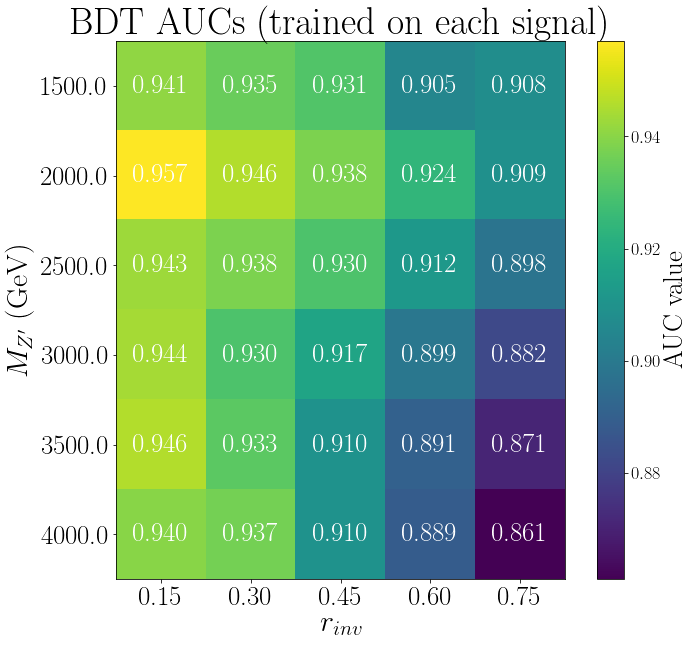

In [140]:
plot_signal_aucs_from_lp(bdts, title='BDT AUCs (trained on each signal)')

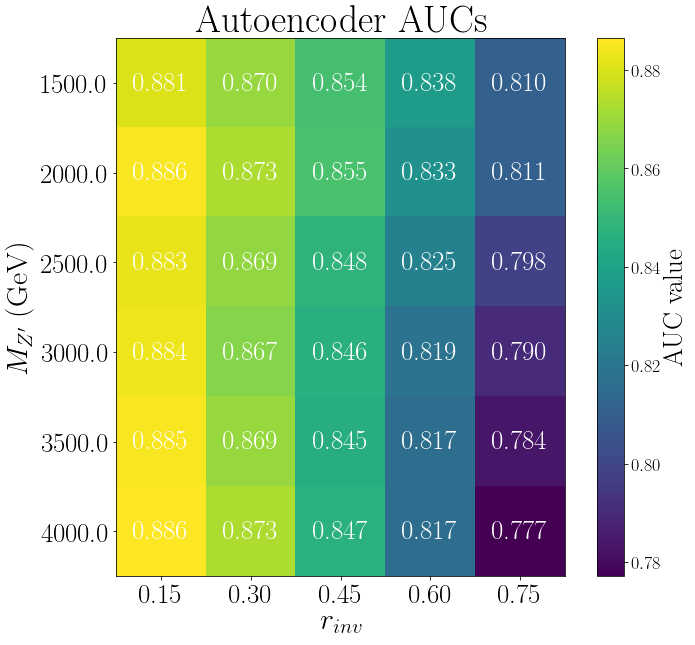

In [208]:
best,ax = plot_signal_aucs(aucs[best_name].to_frame(), title='Autoencoder AUCs')

In [231]:
al = utils.summary(include_outdated=1)

In [237]:
good = al[al.filename == 'hlf_eflow3_8_v36']

In [257]:
sel = al[(al.target_dim == 8) & (al.batch_size == 64)].copy()
sel = sel.set_index('filename').sort_index()

In [267]:
sel['aucs'] = aucs.mean()[aucs.mean().index.isin(sel.index)].sort_index()

In [280]:
import math

cols = 3
rows = int(math.ceil(float(len(s))/cols))

# fig, axs = plt.subplots(rows, cols, figsize=(6*cols, 3*rows))

# axs = axs.flatten()

rets = []
for i,elt in enumerate(sel.index):
    try:
        t = ev.check_training(elt)
    #     t.drop('lr', axis=1).plot(ax=axs[i])
        t['lr'] = t.lr/0.1
    #     t.plot(ax=axs[i])
        rets.append(t.loss.iloc[-1])
    except AssertionError:
        rets.append(None)
        print(elt)
#     axs[i].set_ylim(0.0045, 0.05)
#     axs[i].set_title('{}: {:.4f}'.format(s.loc[elt].time, s.loc[elt].mae_auc), fontsize=18)

# plt.tight_layout()
# plt.show()

sel['mse'] = rets

eflow3_8_v0


In [312]:
sel = sel[sel.arch.apply(len) == len(sel.loc['hlf_eflow3_8_v36'].arch)]
sel = sel[(sel.eflow) & (sel.hlf)]
sel = sel[sel.eflow_base == 3]

In [315]:
sel.loc[
    'hlf_eflow3_8_v36'
].learning_rate

0.00050000000000000001

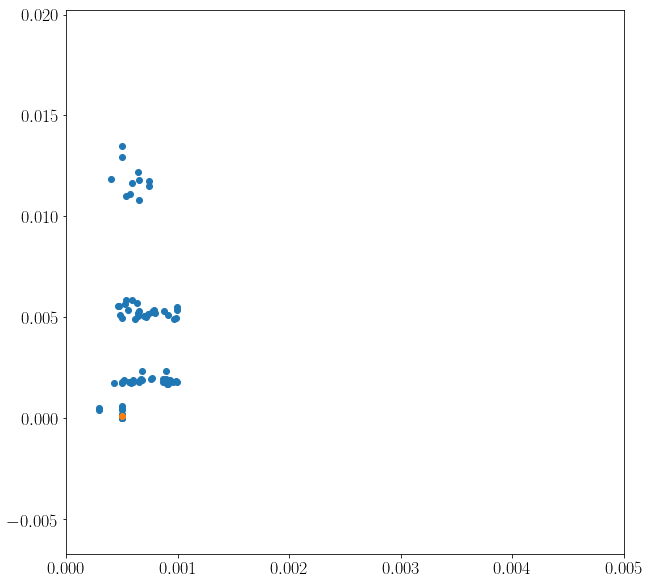

In [314]:
plt.scatter(sel.learning_rate, sel.mse)
plt.scatter(sel.loc['hlf_eflow3_8_v36'].learning_rate, sel.loc['hlf_eflow3_8_v36'].mse)
plt.xlim(0., 0.005)
plt.show()

In [255]:
plt.plot(sel.learning_rate, sel.aucs)

AttributeError: 'DataFrame' object has no attribute 'aucs'

In [224]:
aucs.mean().sort_values()[::-1]

name
hlf_eflow3_8_v36     0.874542
hlf_eflow3_7_v38     0.867213
hlf_eflow3_7_v64     0.866007
hlf_eflow3_7_v109    0.859702
hlf_eflow3_7_v111    0.859387
hlf_eflow3_7_v150    0.859257
hlf_eflow3_9_v6      0.858902
hlf_eflow3_9_v9      0.857775
hlf_eflow3_7_v233    0.857039
hlf_eflow3_7_v51     0.855673
hlf_eflow3_8_v35     0.855367
hlf_eflow3_7_v54     0.854444
hlf_eflow3_7_v195    0.853655
hlf_eflow3_7_v175    0.852927
hlf_eflow3_8_v133    0.852836
hlf_eflow3_7_v23     0.852627
hlf_eflow3_7_v12     0.852612
hlf_eflow3_7_v52     0.852581
hlf_eflow3_7_v132    0.852443
hlf_eflow3_7_v63     0.851397
hlf_eflow3_7_v21     0.851350
hlf_eflow3_7_v70     0.851176
hlf_eflow3_8_v68     0.850807
hlf_eflow3_7_v56     0.850503
hlf_eflow3_7_v136    0.850457
hlf_eflow3_7_v123    0.849265
hlf_eflow3_7_v146    0.848654
hlf_eflow3_7_v15     0.848542
hlf_eflow3_7_v47     0.848055
hlf_eflow3_7_v259    0.847962
                       ...   
hlf_eflow3_6_v41     0.766794
hlf_eflow3_7_v573    0.766317
hlf_e

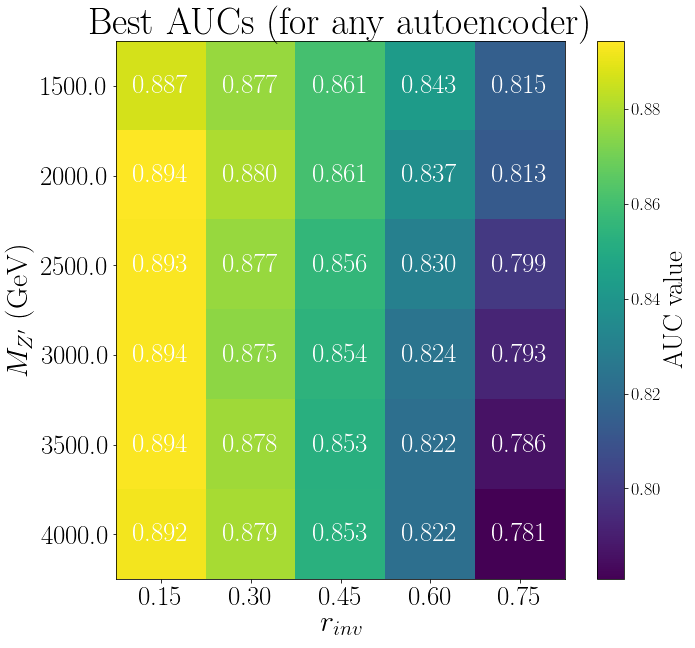

In [216]:
overall,ax = plot_signal_aucs(aucs.drop([c for c in aucs.columns if c not in cut[cut.total_loss < 0.002].index], axis=1), do_max=True)

In [ ]:
diff = (bdts - best) / ((bdts + best)/2.)*100.
ax = plot_signal_aucs_from_lp(diff, title='\% Difference, AE and BDT AUCs', barlabel='', cmap='viridis_r')
ax.images[-1].colorbar.remove()
cb = plt.colorbar(ticks=range(2,10))
cb.ax.set_yticklabels(['{}\%'.format(x) for x in range(3,10)])

plt.tight_layout()
plt.show()

In [ ]:
from mpl_toolkits import mplot3d


arr_to_3d = diff.copy()
x, y, z, = np.asarray(pd.melt(arr_to_3d.reset_index(), id_vars='index').values).astype(float).T

fig = plt.figure()
# x = np.tile(varc.index, [len(varc.columns),1,]).T
# y = np.tile(varc.columns, [len(varc.index),1])
# z = varc.values
ax = plt.axes(projection='3d')
ax.plot_trisurf(x,y,z,cmap='viridis')
ax.view_init(45, 270 + 30)
ax.set_xlabel(r'$Z^\prime$ mass (GeV)')
ax.set_ylabel(r'$r_{inv}$')
ax.set_zlabel(r'\% Difference')
plt.show()

In [ ]:
def histby(aucs, category, bins=20, lines=False, stacked=False, histtype='step', alpha=1, cat_name=None):
    if cat_name is None:
        cat_name = category
    tab = aucs.reset_index()
    cats = ['mass', 'nu']
    tab['mass'] = tab.mass_nu_ratio.map(lambda x: x[0])
    tab['nu'] = tab.mass_nu_ratio.map(lambda x: x[1])
    tab = tab.drop('mass_nu_ratio', axis=1)
    
    tab = tab.drop([m for m in cats if m != category], axis=1)
    groups = tab.groupby(category).apply(lambda x: x.values.flatten())
    
    
    rng = aucs.values.min(), aucs.values.max() 
    if stacked:
        histtype=None
    
    if lines:
        vals = np.linspace(rng[0], rng[1], bins + 1)
        cnts = np.asarray([np.histogram(g, bins=vals)[0] for g in np.asarray(groups.values)])
        
        x = vals[:-1] + np.diff(vals)/2
        ys = np.asarray(cnts)
        for y,label in zip(ys, groups.index):
            plt.plot(x, y, label=label)
        plt.legend(title=cat_name)
        
        return plt.gca()

    rets = plt.hist(np.asarray(groups.values), bins=bins, range=rng, stacked=stacked, alpha=alpha, histtype=histtype, label=[val for val in groups.index])
    plt.legend(title=cat_name)
    return plt.gca()


In [ ]:
fac = 1.5
ax = histby(aucs, 'nu', lines=False, alpha=1, histtype='step', bins=80, cat_name='$r_{inv}$')
lg = plt.legend(fontsize=12*fac, title=r'$r_{inv}$')
lg.get_title().set_fontsize(20*fac) 
plt.title('AUC Distributions for all Trainings\n(grouped by $r_{inv}$)', fontsize=25*fac)
plt.ylabel('Count', fontsize=20*fac)
plt.xlabel('AUC', fontsize=20*fac)
plt.xticks(fontsize=18*fac)
plt.yticks(fontsize=18*fac)
plt.show()

In [ ]:
ax = histby(aucs, 'mass', lines=True, alpha=1, histtype='step', bins=15, cat_name='$M_{Z^+}$')
plt.title('AUC distributions for signals over all trainings, grouped by $M_{Z^\prime}$')
plt.show()

In [ ]:
import scipy.stats

def plot_nu_vs_aucs(aucs, n=None):

    sort = aucs.loc[:,aucs.mean().sort_values()[::-1].index]
    # c = 5
    if n is None:
        n = len(sort.columns)
        
    subset = sort.iloc[:,:n]
    
    means = subset.mean(axis=1)
    mid = np.percentile(aucs, 50, axis=1)
    lower = mid - np.percentile(aucs, 75, axis=1)
    upper = np.percentile(aucs, 25, axis=1) - mid
    bars = np.asarray([upper, lower]).T
    
    
    masses, nus = np.asarray(map(np.asarray, means.index)).T
    mean_vals = means.values

    
    plt.figure(figsize=(12,9))
    
    for mass in sorted(set(masses)):
        idx = masses == mass
        
        plt.errorbar(nus[idx], mean_vals[idx], marker='o', yerr=bars[idx].T, label='{} GeV'.format(mass), capsize=8.0, alpha=0.6)
        
    
    plt.xlabel('Nu Fraction')
    plt.ylabel('Average AUC')
    plt.xticks(np.unique(nus))
    plt.legend(title=r'$Z^{\prime}$ Mass')
    plt.title('')
    plt.show()
#     return means, lower, upper
    
plot_nu_vs_aucs(aucs)

In [ ]:
def plot_mass_vs_aucs(aucs, n=None):
    
    sort = aucs.loc[:,aucs.mean().sort_values()[::-1].index]
    # c = 5
    if n is None:
        n = len(sort.columns)
        
    subset = sort.iloc[:,:n]
    
    means = subset.mean(axis=1)
    mid = np.percentile(aucs, 50, axis=1)
    lower = mid - np.percentile(aucs, 75, axis=1)
    upper = np.percentile(aucs, 25, axis=1) - mid
    bars = np.asarray([upper, lower]).T
    
    
    masses, nus = np.asarray(map(np.asarray, means.index)).T
    mean_vals = means.values
    
    plt.figure(figsize=(12,9))
    
    for nu in sorted(set(nus)):
        idx = nus == nu
        plt.errorbar(masses[idx], mean_vals[idx], marker='o', yerr=bars[idx].T, label='{}'.format(nu), capsize=8.0, alpha=0.6)
        
    plt.xlabel('Mass (GeV)')
    plt.ylabel('Average AUC')
    plt.xticks(np.unique(masses))
    plt.legend(title=r'$r_{inv}$')
    plt.title('Signal $Z^\prime$ mass vs. Average AUC (top {} AEs)'.format(n))
    plt.tight_layout()
    plt.show()
    
plot_mass_vs_aucs(aucs)

# important
`data_holder` basically loads all signal data into memory at once, while `auc_getter` gets and generates errors, reconstructed data, and normalized data on a gievn training run. Both of these things are critical to the later plotting

In [ ]:
reload(ev)

In [ ]:
eflow_base = 3

dholder = ev.data_holder(
    qcd='data/background/base_3/*.h5',
    **{os.path.basename(p): '{}/base_{}/*.h5'.format(p, eflow_base) for p in glob.glob('data/all_signals/*')}
)

dholder.load()
dists = {v.name: v for v in dholder.get('data')}

# signal = utils.data_table(pd.concat([v.df for v in dists.values() if v.name.startswith('Zprime')]), name='Z^+ Dark (Average)')
qcd = dists['qcd']


In [ ]:
dists_subset = [v for v in dists.values() if v.name.startswith('Zprime')]
size = min(map(len, dists_subset))
signal = utils.data_table(pd.concat([v.df.iloc[:size] for v in dists_subset]), name='Z^+ Dark (Average)')
signal_combined = pd.concat([pd.concat([v.df, pd.Series(np.repeat(k, len(v)), name='key')], axis=1) for k,v in dists.items() if k.startswith('Zprime')])
sc = signal_combined

sc['mass'] = sc.key.apply(lambda x: int(x.split('_')[1].rstrip('GeV')))
sc['nu'] = sc.key.apply(lambda x: float(x.split('_')[-1])/100.)
# sc.head()

In [ ]:
def mae_minus_etaphi(true, pred):
    return np.abs((true[:,2:] - pred[:,2:])).mean(axis=1)


tf.reset_default_graph()
agetter = ev.auc_getter(best_name, times=True)
agetter.update_event_range(dholder, percentile_n=1)
test = agetter.get_test_dataset(dholder)
norm, errors, recon = agetter.get_errs_recon(dholder, names=['mae', 'mse', 'mae_minus_etaphi'], functions=['mae', 'mse', mae_minus_etaphi])
aucs_ = agetter.get_aucs(errors, metrics=['mae', 'mse', 'mae_minus_etaphi'])
fmt = agetter.auc_metric(aucs_)

signal_recon = utils.data_table(pd.concat([v.df.iloc[:size] for v in recon.values() if v.name.startswith('Zprime')]), name='Z^+ Dark (Average) pred')
signal_norm = utils.data_table(pd.concat([v.df.iloc[:size] for v in norm.values() if v.name.startswith('Zprime')]), name='Z^+ Dark (Average)')
signal_err = utils.data_table(pd.concat([v.df.iloc[:size] for v in errors.values() if v.name.startswith('Zprime')]), name='Z^+ Dark (Average)')

In [ ]:
styles = {
    'Z': {
        'facecolor': 'm',
        'histtype': 'step',
        'fill': True,
        'edgecolor': 'k',
        'label': r'SVJ',
        'alpha': 0.4,
#         'hatch': '/'
    },
    'qcd': {
        'facecolor': 'y',
        'histtype': 'step',
        'fill': True,
        'edgecolor': 'k',
        'label': r'QCD',
        'alpha': 0.4

    },
    'ttbar': {
        'facecolor': 'C0',
        'label': r'$t\bar{t}$',
        'edgecolor': 'w',
        'hatch': '//',
        'fill': True,
        'histtype': 'step',
        'alpha': 0.4

    }
}

order = [
    'ttbar',
    'Z',
    'qcd'
]


var_styles = {
    'ChargedFraction': {
        'xlabel': r'Charged Fraction',
        'fontsize': 20,
    },
    'Pt': {
        'xlabel': r'$\displaystyle p_{T}$',
        'fontsize': 20,
        'range': (0., 2000.),
    },
    'Eta': {
        'xlabel': r'$\displaystyle \eta$',
        'fontsize': 20,
#         'range': (0., 0.7),
    },
    'Phi': {
        'xlabel': r'$\displaystyle \phi$',
        'fontsize': 20,
#         'range': (0., 0.7),
    },
    'M': {
        'xlabel': 'Mass',
        'fontsize': 20,
        'range': (0., 500.)
    },
    'mae': {
        'xlabel': 'Reconstruction Error (MAE)',
        'fontsize': 30,
    },
    'mse': {
        'xlabel': 'Reconstruction Error (MSE)',
        'fontsize': 30,
    },
    'mae_minus_etaphi': {
        'xlabel': 'Reconstruction Error (MAE - eta/phi)',
        'fontsize': 30,
    },
    'PTD': {
        'xlabel': 'PTD',
        'fontsize': 20,
    },
    'Axis2': {
        'xlabel': 'Axis_2',
        'fontsize': 20,
        'range': (0, 0.2)
    }
}

# more than needed
for i in range(100):
    var_styles['eflow {}'.format(i)] = {}
    var_styles['eflow {}'.format(i)]['xlabel'] = "Variable {}".format(i)
    var_styles['eflow {}'.format(i)]['fontsize'] = 20

eflow_ranges = {
    1: (0,0.6),
    2: (0,0.5),
    3: (0,0.4),
    4: (0,0.4),
    5: (0,0.25),
    6: (0,0.15),
    7: (0,0.2),
    8: (0,0.15),
    9: (0,0.3),
    10: (0,0.2),
    11: (0,0.15),
    12: (0,0.15)
}

for num,rng in eflow_ranges.items():
    var_styles['eflow {}'.format(num)]['range'] = rng

### Pre-use histograms

Thing to convert data into column-based shit:

In [ ]:
from collections import OrderedDict

def converter(toplot): 
    colsets = [tuple(x.columns) for x in toplot.values()]
    assert(len(set(colsets)) == 1)
    var = colsets[0]

    names = sorted(toplot.keys())

    out = OrderedDict()
    for name in names:
        for v in var:
            if v not in out:
                out[v] = OrderedDict()
            out[v][name] = toplot[name][v]

    return out

In [ ]:
data = converter({'Z': signal, 'qcd': test})

bins=50
names="*"
ylabel=None
normed=1
xlog=False
ylog=False
pileup=False
m1 = 20./4.
m2 = 14./3.


fs = 18
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['xtick.labelsize']=fs
plt.rcParams['ytick.labelsize']=fs
matplotlib.rcParams.update({'font.size': 18})

rows, cols = (6,4)
f, axs = plt.subplots(rows, cols, figsize=(cols*m1, rows*m2))
axs = axs.flatten()
#     f.suptitle("Input Variables", y=1.02, fontsize=30)
ogbins = bins
i = 0
for d,v in data.items():
    var_style = var_styles[d].copy()

    if 'bins' in var_style:
        bins = var_style.pop('bins')
    else:
        bins = ogbins

    if 'range' in var_style:
        rng = var_style.pop('range')
    else:
        rng = map(lambda f: f(map(f, v.values())), [min, max])
    ax = axs[i]

    if 'Variable' in var_style['xlabel']:
        var_style['xlabel'] = "EFP " + var_style['xlabel'] 
#         keys = reversed(sorted([k for k in v.keys() if len(k.split()) == 1]) + sorted([k for k in v.keys() if len(k.split()) > 1]))
    for k in v.keys():

        datum = v[k]

        if pileup:
            datum[datum < rng[0]] = rng[0]
            datum[datum > rng[1]] = rng[1]
        nbins = bins
        if xlog:
            nbins = np.geomspace(rng[0], rng[1], bins)

        style = styles[k].copy()

#             style['alpha'] = 0.3
        ax.hist(datum, range=rng, bins=nbins, normed=normed, **style)


        ax.set_xlabel(**(var_style))
#             ax.set_yscale('log')
        if xlog:
            ax.set_xscale('log')
        if ylog:
            ax.set_yscale('log', nonposy='clip')
        if ylabel is not None:
            ax.set_ylabel(ylabel)

    i += 1

handles,labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc=(0.8, 0.1), fontsize=40)
for x in axs[i:]:
    f.delaxes(x)


### Post-all

In [ ]:
data = converter({
    'Z pred': signal_recon,
    'qcd pred': recon['qcd pred'],
    'Z': signal, 
    'qcd': test
})

bins=50
names="*"
ylabel=None
normed=1
xlog=False
ylog=False
pileup=False
m1 = 20./4.
m2 = 14./3.

recon_kwd = 'pred'
# dists = e.dists_dict.copy()
# dists['qcd'] = e.test
# data = plotdata({recon_kwd : e.recons_dict, 'NONE': dists}, names=names)

fs = 12
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['xtick.labelsize']=fs
plt.rcParams['ytick.labelsize']=fs
matplotlib.rcParams.update({'font.size': 18})

rows, cols = (6,4)
f, axs = plt.subplots(rows, cols, figsize=(cols*m1, rows*m2))
axs = axs.flatten()
# f.suptitle("Feature Reconstructions", y=1.02, fontsize=30)
ogbins = bins
i = 0

for da,v in data.items():
    
    var_style = var_styles[da].copy()
    if 'Variable' in var_style['xlabel']:
        var_style['xlabel'] = "EFP " + var_style['xlabel'] 
    
    if 'bins' in var_style:
        bins = var_style.pop('bins')
    else:
        bins = ogbins

    if 'range' in var_style:
        rng = var_style.pop('range')

    else:
        rng = map(lambda f: f(map(f, v.values())), [min, max])
    ax = axs[i]

#         keys = reversed(sorted([k for k in v.keys() if len(k.split()) == 1]) + sorted([k for k in v.keys() if len(k.split()) > 1]))
    for k in v.keys():

        datum = v[k]
        reconstructed = False
        kp = k 
        if recon_kwd in k:
            reconstructed = True 

            kp = k.replace(recon_kwd, '').strip()

        if pileup:
            datum[datum < rng[0]] = rng[0]
            datum[datum > rng[1]] = rng[1]
        nbins = bins
        if xlog:
            nbins = np.geomspace(rng[0], rng[1], bins)

        style = styles[kp].copy()

#             style['alpha'] = 0.3
        if reconstructed:
            hist,bins = np.histogram(datum, range=rng, bins=nbins, normed=normed)

            style['color'] = style['facecolor']
            style['linewidth'] = 2
            style['label'] = style['label'] + ', (pred)'
            for var in ['histtype', 'fill', 'facecolor', 'edgecolor', 'hatch', 'alpha']:
                if var in style:
                    style.pop(var)

            ax.plot(bins[:-1] + np.diff(bins)/2., hist, marker='+', alpha=1, **style)
#                 ax.scatter(bins[:-1] + np.diff(bins)/2., hist, marker='+', edgecolor='k', **style)
        else:
            ax.hist(datum, range=rng, bins=nbins, normed=normed, **style)

        ax.set_xlabel(**(var_style))
#             ax.set_yscale('log')
        if xlog:
            ax.set_xscale('log')
        if ylog:
            ax.set_yscale('log', nonposy='clip')
        if ylabel is not None:
            ax.set_ylabel(ylabel)

    i += 1

handles,labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc=(.7825,.1), fontsize=33)
for x in axs[i:]:
    f.delaxes(x)

In [ ]:
data = converter({
    'Z pred': signal_recon,
    'qcd pred': recon['qcd pred'],
    'Z': signal, 
    'qcd': test
})

bins=50
names="*"
ylabel=None
normed=1
xlog=False
ylog=False
pileup=False
m1 = 19./4.
m2 = 14./3.

recon_kwd = 'pred'
# dists = e.dists_dict.copy()
# dists['qcd'] = e.test
# data = plotdata({recon_kwd : e.recons_dict, 'NONE': dists}, names=names)

fs = 20
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['xtick.labelsize']=fs
plt.rcParams['ytick.labelsize']=fs
matplotlib.rcParams.update({'font.size': 18})

rows, cols = (6,4)
f, axs = plt.subplots(rows, cols, figsize=(cols*m1, rows*m2))
axs = axs.flatten()
# f.suptitle("Feature Reconstructions", y=1.02, fontsize=30)
ogbins = bins
i = 0

for da,v in data.items():
    
    var_style = var_styles[da].copy()
    if 'Variable' in var_style['xlabel']:
        var_style['xlabel'] = "EFP " + var_style['xlabel'] 
    
    if 'bins' in var_style:
        bins = var_style.pop('bins')
    else:
        bins = ogbins

    if 'range' in var_style:
        rng = var_style.pop('range')

    else:
        rng = map(lambda f: f(map(f, v.values())), [min, max])
    ax = axs[i]

#         keys = reversed(sorted([k for k in v.keys() if len(k.split()) == 1]) + sorted([k for k in v.keys() if len(k.split()) > 1]))
    for k in v.keys():

        datum = v[k]
        reconstructed = False
        kp = k 
        if recon_kwd in k:
            reconstructed = True 

            kp = k.replace(recon_kwd, '').strip()

        if pileup:
            datum[datum < rng[0]] = rng[0]
            datum[datum > rng[1]] = rng[1]
        nbins = bins
        if xlog:
            nbins = np.geomspace(rng[0], rng[1], bins)

        style = styles[kp].copy()

#             style['alpha'] = 0.3
        if reconstructed:
            hist,bins = np.histogram(datum, range=rng, bins=nbins, normed=normed)

            style['color'] = style['facecolor']
            style['linewidth'] = 2
            style['label'] = style['label'] + ', (pred)'
            for var in ['histtype', 'fill', 'facecolor', 'edgecolor', 'hatch', 'alpha']:
                if var in style:
                    style.pop(var)

            ax.plot(bins[:-1] + np.diff(bins)/2., hist, marker='+', alpha=1, **style)
#                 ax.scatter(bins[:-1] + np.diff(bins)/2., hist, marker='+', edgecolor='k', **style)
        else:
            ax.hist(datum, range=rng, bins=nbins, normed=normed, **style)

        var_style['fontsize'] = 30
        ax.set_xlabel(**(var_style))
        
#             ax.set_yscale('log')
        if xlog:
            ax.set_xscale('log')
        if ylog:
            ax.set_yscale('log', nonposy='clip')
        if ylabel is not None:
            ax.set_ylabel(ylabel)
        ax.set_yticklabels([])

    i += 1

handles,labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc=(.7825,.1), fontsize=33)
for x in axs[i:]:
    f.delaxes(x)

In [ ]:
loss_to_use = 'mse'
loss_range = (0, 0.05)

In [ ]:
import random

N0 = 12000

# N = 6*N0/5


keys = errors.keys()
keys.remove('qcd')
keys = pd.DataFrame(keys, columns=['key'])
keys['nu'] = keys.key.apply(lambda x: x.split('_')[-1]).astype(float)/100.
keys['mass'] = keys.key.apply(lambda x: x.split('_')[-2].replace('GeV', '')).astype(int)
se_idx = random.sample(list(set(signal_err.index)), N0/6)

newdata = {}
for nu, gp in keys.groupby('nu').key:
     newdata[nu] = pd.concat([errors[k].df.loc[se_idx] for k in gp])
    

# se_idx = random.sample(list(set(signal_err.index)), N//30)
qe_idx = random.sample(range(len(errors['qcd'])), N0)

inp = {'qcd': errors['qcd'].iloc[qe_idx]}
inp.update(newdata)
data = converter(inp)
for k in data.keys():
    if k != loss_to_use:
        data.pop(k)

bins=40
ylabel=None
normed=0
xlog=False
ylog=True
pileup=False
rng=loss_range

#     recon_kwd = '(Reconstructed)'
#     data = plotdata(e.errs_dict, names=names, drop=drop)

fs = 18
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['xtick.labelsize']=fs
plt.rcParams['ytick.labelsize']=fs
matplotlib.rcParams.update({'font.size': 30})

#     rows, cols = (1,1)
f, ax = plt.subplots(1, 1, figsize=(2*m1, 2*m2))

#     f.suptitle("Input Variables", y=1.02, fontsize=30)
ogbins = bins

stack = []
for d,v in data.items():
    if 'bins' in var_styles[d]:
        bins = var_styles[d].pop('bins')
    else:
        bins = ogbins

    if 'range' in var_styles[d]:
        rng = var_styles[d].pop('range')
    elif rng is None:
        rng = map(lambda f: f(map(f, v.values())), [min, max])


#         keys = reversed(sorted([k for k in v.keys() if len(k.split()) == 1]) + sorted([k for k in v.keys() if len(k.split()) > 1]))
       
    for k in v.keys():

        datum = v[k]

        if pileup:
            datum[datum < rng[0]] = rng[0]
            datum[datum > rng[1]] = rng[1]
        nbins = bins
        if xlog:
            nbins = np.geomspace(rng[0], rng[1], bins)

        if k in styles:
            style = styles[k].copy()
            ax.hist(datum, range=rng,bins=nbins, normed=normed, **style)
        else:
            ax.hist(datum, range=rng,bins=nbins, normed=normed, label=r'SVJ, $r_{inv} = ' + '{}$'.format(str(k)), histtype='step')
            stack.append(np.histogram(datum, range=rng, bins=nbins, normed=normed))
            
        var_style = var_styles[d].copy()
        if 'Variable' in var_style['xlabel']:
            var_style['xlabel'] = "EFP " + var_style['xlabel'] 

        ax.set_xlabel(**(var_style))
#             ax.set_yscale('log')
        if xlog:
            ax.set_xscale('log')
        if ylog:
            plt.ylim(1e1,1e4)

            ax.set_yscale('log', nonposy='clip')
        if ylabel is not None:
            ax.set_ylabel(ylabel)

# ax.set_ylabel('Arbitrary Units')
# ax.set_yticklabels([])
# plt.yscale('log')

handles,labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc=(.62,.56), fontsize=22)
plt.title('Reconstruction Error\n($N$ = {} Events/Class)'.format(N0))
plt.ylabel('Count')



In [ ]:
N = 12000

se_idx = random.sample(range(len(signal_err.index)), N)
qe_idx = random.sample(range(len(errors['qcd'])), N)
data = converter({'Z': signal_err.iloc[se_idx], 'qcd': errors['qcd'].iloc[qe_idx]})
for k in data.keys():
    if k != loss_to_use:
        data.pop(k)
# print(data['mae']['Z'].max())
bins=50
ylabel=None
normed=0
xlog=False
ylog=True
pileup=False
rng=loss_range
split=True

#     recon_kwd = '(Reconstructed)'
#     data = plotdata(e.errs_dict, names=names, drop=drop)

fs = 18
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['xtick.labelsize']=fs
plt.rcParams['ytick.labelsize']=fs
matplotlib.rcParams.update({'font.size': 30})

#     rows, cols = (1,1)
f, ax = plt.subplots(1, 1, figsize=(2*m1, 2*m2))

#     f.suptitle("Input Variables", y=1.02, fontsize=30)
ogbins = bins

for d,v in data.items():
    if 'bins' in var_styles[d]:
        bins = var_styles[d].pop('bins')
    else:
        bins = ogbins

    if 'range' in var_styles[d]:
        rng = var_styles[d].pop('range')
    elif rng is None:
        rng = map(lambda f: f(map(f, v.values())), [min, max])


#         keys = reversed(sorted([k for k in v.keys() if len(k.split()) == 1]) + sorted([k for k in v.keys() if len(k.split()) > 1]))
       
    for k in v.keys():

        datum = v[k]

        if pileup:
            datum[datum < rng[0]] = rng[0]
            datum[datum > rng[1]] = rng[1]
        nbins = bins
        if xlog:
            nbins = np.geomspace(rng[0], rng[1], bins)

        style = styles[k].copy()

#             style['alpha'] = 0.3
        ax.hist(datum, range=rng,bins=nbins, normed=normed, **style)

        var_style = var_styles[d].copy()
        if 'Variable' in var_style['xlabel']:
            var_style['xlabel'] = "EFP " + var_style['xlabel'] 

        ax.set_xlabel(**(var_style))
#             ax.set_yscale('log')
        if xlog:
            ax.set_xscale('log')
        if ylog:
            plt.ylim(1e1,1e4)

            ax.set_yscale('log', nonposy='clip')
        if ylabel is not None:
            ax.set_ylabel(ylabel)

# ax.set_ylabel('Arbitrary Units')
# ax.set_yticklabels([])
# plt.yscale('log')
handles,labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc=(.7,.71), fontsize=30)
plt.title('Reconstruction Error\n($N$ = {} Events/Class)'.format(N))
plt.ylabel('Count')



In [ ]:
# fig,axes = plt.subplots(5, 4, figsize=(20,20))

# srecon = np.abs(signal_recon.reset_index(drop=True) - signal.reset_index(drop=True))
# qrecon = np.abs(test.reset_index(drop=True) - recon['qcd pred'].reset_index(drop=True))

# cols = srecon.columns
# cnt = 0
# for i in range(len(axes)):
#     for j in range(len(axes[i])):
#         if cnt >= len(cols):
#             break
#         ax = axes[i,j]
        
#         c = cols[cnt]
#         scol = srecon[c].values
#         qcol = qrecon[c].values
        
#         rng = min([scol.min(), qcol.max()]), max([scol.max(), qcol.max()])
#         ax.hist(scol, range=rng, bins=40, color='red', histtype='step', normed=True)
#         ax.hist(qcol, range=rng, bins=40, color='blue', histtype='step', normed=True)
#         ax.set_xlabel(c)
#         ax.set_yscale('log')

#         #.hist(ax=ax, bins=40, color='blue', histtype='step')
#         cnt += 1

# ax.hist([], range=rng, bins=40, color='red', histtype='step', label='svj')
# ax.hist([], range=rng, bins=40, color='blue', histtype='step', label='qcd')
# axes[i,j].hist(srecon.mean(axis=1), range=(0,100), color='red', histtype='step', bins=40, normed=1)
# axes[i,j].hist(qrecon.mean(axis=1), range=(0,100), color='blue', histtype='step', bins=40, normed=1)
# plt.legend()
# plt.show()

In [ ]:
import sklearn.metrics

se = signal_err
qe = errors['qcd']

# sklearn.metrics.auc(se qe)

In [ ]:
maeroc = utils.roc_auc_dict([qe], [se], metrics='mae').values()[0]
# plt.plot(roc[0], roc[1])

# srecon = np.abs(signal_recon.reset_index(drop=True) - signal.reset_index(drop=True))
# qrecon = np.abs(dists['qcd'].reset_index(drop=True) - recon['qcd pred'].reset_index(drop=True))

roc = utils.roc_auc_dict([test], [signal], metrics=list(signal.columns)).values()[0]
roc.update(maeroc)

In [ ]:
pd.DataFrame([[elt, roc[elt]['auc']] for elt in roc], columns=['var', 'auc']).sort_values('auc')[::-1]

# for elt in roc:
#     rocc = roc[elt]['auc']
#     print(elt, rocc)
#     plt.plot(rocc[0], rocc[1], label=elt)
    
# plt.legend()
# plt.show()

In [ ]:
from matplotlib import lines as mplines
# errs = e.roc(figsize=10, yscale='log', xscale='log', figname='SVJ vs. QCD error', fontsize=20, show_plot=0)

plt.figure(figsize=(10,10))
aucplot = aucs_.copy()

keys = aucplot.keys()
# keys.remove('qcd')
keys = pd.DataFrame(keys, columns=['key'])
keys['nu'] = keys.key.apply(lambda x: x.split('_')[-1]).astype(float)/100.
keys['mass'] = keys.key.apply(lambda x: x.split('_')[-2].replace('GeV', '')).astype(int)
se_idx = random.sample(list(set(signal_err.index)), N0/6)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# all_colors = prop_cycle.by_key()['color']
all_lines = ['-', '--', '-.', ':', '-']
all_markers = ['x', 'o', 'v', 'D', 's', 'P']
# all_lines = ["s", "o", "d", "x", "1"]

masses, nus = map(set, np.asarray([[err.split('_')[1], '{:.2f}'.format(int(err.split('_')[2])/100.)] for err in errors.keys() if len(err.split('_')) >= 3]).T)
# colors = OrderedDict([(nu, all_colors[i]) for i,nu in enumerate(nus)])
lines = {nu: '-' for i,nu in enumerate(nus)}
markers = {mass: all_markers[i] for i,mass in enumerate(masses)}


dots = np.logspace(-3, -2, len(aucplot))
# index = np.argsort([(k, v['mae']['auc']) for k,v in aucplot.items()],axis=0)[:,1]
index = np.argsort([(k, v['mae']['roc'][1][np.argmin(abs(v['mae']['roc'][0] - 2*1e-3))]) for k,v in aucplot.items()], axis=0)[:,1]

used_labels = set()
used_styles = OrderedDict()

for i,(nu, gp) in enumerate(keys.groupby('nu').key):
    for a in gp:
        for typ in aucplot[a]:
            if typ != 'mae':
                continue
            mass,nu = a.split('_')[1:]
            nu = '{:.2f}'.format(int(nu)/100.)
            roc = aucplot[a][typ]['roc']
            auc = aucplot[a][typ]['auc']

            lab = r'${}$'.format(nu)
            if lab in used_labels:
                lab = None
            used_labels.add(lab)


    #         nex = dots[index[i]]
            idxs = [np.argmin(abs(roc[0] - x)) for x in np.logspace(-3, 0, 10)]
            nex = 2e-3
    #         xplt = np.argmin(abs(roc[0] - nex))

            
            plt.plot(roc[0], roc[1], linestyle=lines[nu], c=colors[i], label=lab, linewidth=0.9) 
            used_styles[(nu, mass)] = plt.plot(
                roc[0][idxs], roc[1][idxs], marker=None,#markers[mass],
                markeredgecolor=colors[i], markerfacecolor='None',
                markersize=6, linestyle='None'
            )
            
        
    #, label=r'${}$, Nu={}'.format(mass, nu))
plt.plot(np.arange(0,1.001,0.001), np.arange(0,1.001,0.001), linestyle='--', c='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Signal Discrimination ROC Curve')
# plt.yscale('log')#
plt.xscale('log')
plt.legend(title=r'$r_{inv}$')
plt.ylim(1e-3, 1)
plt.xlim(1e-3, 1)

plt.show()

In [ ]:
df = pd.DataFrame({k: v['mae'] for k,v in aucplot.items()}).T['auc'].to_frame()
df['nu'] = [int(x.split('_')[2])/100. for x in df.index.values]
df['mass'] = [int(x.split('_')[1].rstrip('GeV')) for x in df.index.values]
df = df.pivot('mass', 'nu', 'auc')

In [ ]:
qcd_mae = (agetter.get_test_dataset(dholder).df - recon['qcd pred'].df).abs()
signal_mae = (signal.df - signal_recon.df).abs()

data_table :: plotting distrubution(s) for table(s) ['qcd', 'signal']


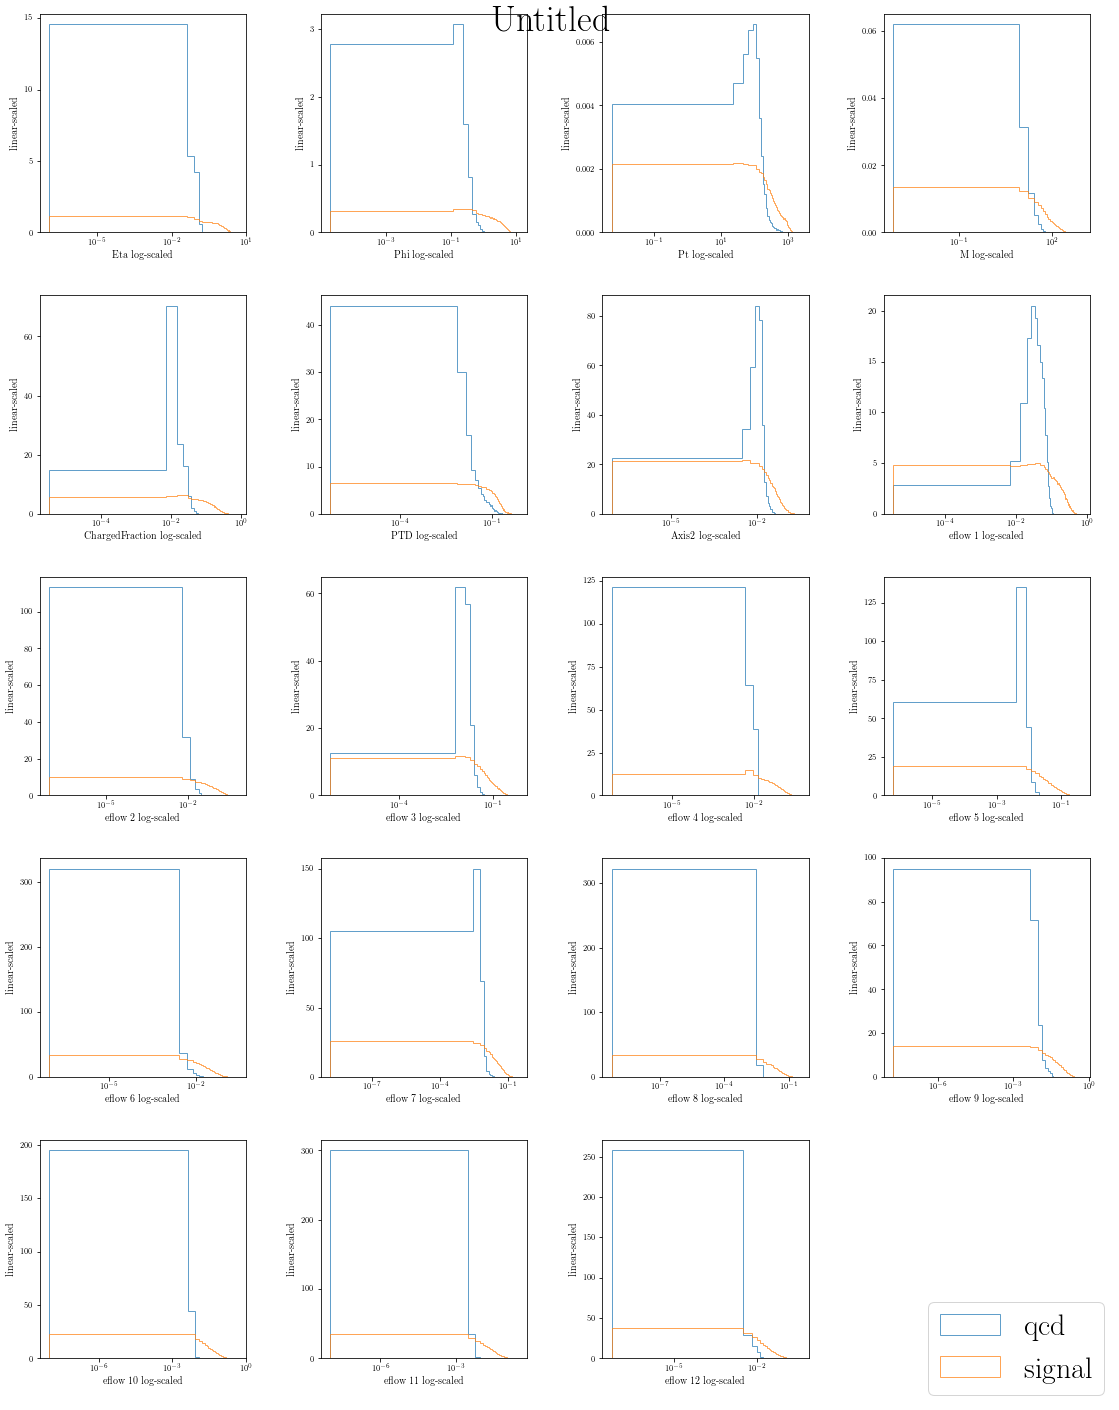

In [159]:
utils.data_table(qcd_mae, name='qcd').plot(utils.data_table(signal_mae, name='signal'), normed=1, bins=100, xscale='log')